In [1]:
import numpy as np
from numpy.fft import fftn
import matplotlib.pyplot as plt

In [14]:
# Load in mock catalog 
data = np.load("../data/mock_catalog_v5.npz")
positions = data['pos']

In [3]:
# Assign mock particles to a grid
def cic_grid(positions, Ngrid, boxsize):
    # Create a 3d grid
    density = np.zeros((Ngrid, Ngrid, Ngrid), dtype=np.float32)
    # Convert physical coordinates to grid coordinates
    cell = positions / (boxsize / Ngrid)
    # Find index of the grid cell for each particle 
    i = np.floor(cell).astype(int) % Ngrid # %Ngrid wraps positions that land outside the box 
    # How far the particle is from the grid points in all 3 dimensions
    d = cell - i

    # Distribute weights using Cloud-in-Cell
    # For CIC we assign weights to the 8 neighboring grid cells using the particle's 3D position
    for dx in (0,1):
        # Weight is 1 - offset for the lower axis point and weight equals offset for the upper axis point
        if dx == 0: 
            wx = (1 - d[:,0]) 
        else: 
            wx = d[:,0]
        for dy in (0,1):
            if dy == 0: 
                wy = (1 - d[:,1])
            else: 
                wy = d[:, 1]
            for dz in (0,1):
                if dz == 0:
                    wz = (1 - d[:,2]) 
                else: 
                    wz = d[:, 2]
                ii = (i[:,0] + dx) % Ngrid
                jj = (i[:,1] + dy) % Ngrid
                kk = (i[:,2] + dz) % Ngrid
                w = wx * wy * wz
                # Add the weights for each grid cell
                np.add.at(density, (ii, jj, kk), w)
    # Return the density of particles for each grid cell
    return density


In [4]:
# Set parameters
Ngrid = 256
boxsize = 1380  # Mpc/h
rho = cic_grid(positions, Ngrid, boxsize)

In [5]:
# Compute overdensity δ = (ρ - mean)/mean
delta = (rho - rho.mean()) / rho.mean()

# Take the FFT of the overdensity field
delta_k = fftn(delta)
power_k = np.abs(delta_k)**2  # complex modulus squared

# Bin P(k) in spherical shells
# Compute k-grid
kx = np.fft.fftfreq(Ngrid, d=boxsize/Ngrid) * 2*np.pi # Mutliply by 2pi to convert to wavenumbers
# Grid is the same for all 3 axes
ky = kx
kz = kx
kx,ky,kz = np.meshgrid(kx,ky,kz, indexing='ij')
# Compute the magnitude
kk = np.sqrt(kx**2 + ky**2 + kz**2)

In [6]:
# Create 50 k bins
k_bins = np.linspace(0, kk.max(), 50)
Pk = np.zeros(len(k_bins)-1)

for i in range(len(k_bins)-1):
    # Find the bin index for the k value
    idx = (kk>=k_bins[i]) & (kk<k_bins[i+1])
    # Take the average power within each k shell
    Pk[i] = power_k[idx].mean() * (boxsize**3 / Ngrid**6)  # normalization

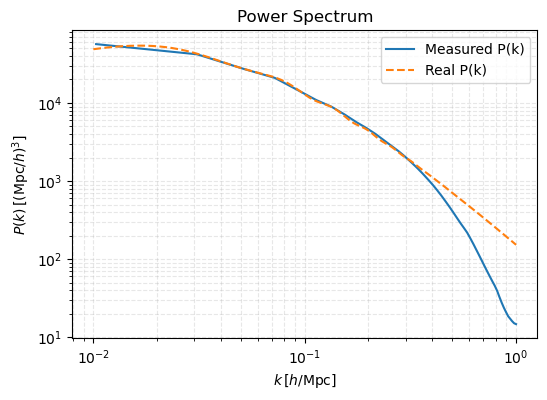

In [15]:
# Compute bin centers
k_mid = 0.5 * (k_bins[1:] + k_bins[:-1])

# Plot log-log power spectrum
plt.figure(figsize=(6,4))
plt.loglog(k_mid, Pk, label='Measured P(k)')

# Compare to real P(k) from nbodykit
real = np.loadtxt("../data/power_spectrum_v5.txt", skiprows=1)
k_theory = real[:, 0]
P_theory = real[:, 1]

plt.loglog(k_theory, P_theory, '--', label='Real P(k)')

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \, [( \mathrm{Mpc}/h)^3 ]$')
plt.title('Power Spectrum')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.show()

In [16]:
np.savetxt('../data/power_spec_npfft_v5.txt', [k_mid, Pk])